In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,32.953417,level_472,level_114,level_249,level_493,level_61,level_399,level_185,level_219,level_223,...,level_455,level_421,level_118,level_450,level_320,level_267,level_467,level_450,level_230,level_79
1,56.313112,level_256,level_223,level_281,level_234,level_218,level_260,level_94,level_357,level_483,...,level_22,level_355,level_55,level_438,level_447,level_2,level_253,level_296,level_169,level_31
2,14.644008,level_8,level_401,level_188,level_495,level_402,level_249,level_300,level_300,level_29,...,level_474,level_153,level_276,level_363,level_260,level_116,level_262,level_335,level_272,level_349
3,17.347639,level_257,level_412,level_168,level_165,level_476,level_272,level_116,level_479,level_225,...,level_361,level_353,level_276,level_358,level_263,level_316,level_138,level_104,level_251,level_21
4,-3.090683,level_344,level_415,level_416,level_223,level_485,level_169,level_441,level_194,level_186,...,level_38,level_285,level_374,level_241,level_98,level_385,level_187,level_247,level_146,level_139


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-4.673179,16.307761,-1.835570,-3.274785,-4.836221,13.347705,11.445770,-6.012089,5.777856,-2.621204,...,-4.344973,-7.720059,-15.250439,-6.886434,-0.964033,-15.706591,2.292695,-1.621501,0.501099,8.385406
1,10.148874,14.498385,-7.670774,-2.290139,-2.991847,-7.128922,0.014543,3.887444,5.833638,-9.348501,...,-5.476798,-3.101221,10.104321,-2.997845,-1.096442,10.413723,-0.754989,6.560894,-1.551815,-3.398027
2,1.397137,8.756452,3.797650,9.278713,-9.820176,-18.413746,0.496032,-2.118673,1.203910,-11.344638,...,-5.883330,-6.248407,-10.018048,-1.589503,-16.117634,-1.707205,-3.497092,-5.055679,0.422256,0.495418
3,7.444756,-3.129098,3.243500,-9.729788,-5.116614,3.014591,-0.274780,7.666469,2.714763,-16.932550,...,1.078797,-3.737346,-2.612686,-13.888298,-6.165070,1.342555,4.801690,-10.286528,-3.411152,-0.775671
4,-11.959556,-1.175389,0.046115,-10.127159,-8.447581,9.737756,-3.642272,1.586098,-0.202192,8.430744,...,12.235622,-6.070448,-7.188081,-1.993155,-6.460613,4.172180,2.544103,-4.737562,-9.638839,-11.886692


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-4.308848,9.622860,-1.052080,-2.004236,-1.429330,11.235514,6.655041,-5.417849,4.612841,-2.449054,...,-2.562810,-5.067930,-9.613871,-5.438371,0.000000,-7.045862,0.956835,-0.902832,0.195488,5.075942
1,6.895765,8.683699,-6.683362,-1.550084,-2.109240,-5.820586,0.007585,2.871564,4.006404,-5.084208,...,-3.314760,-1.570601,8.159274,-1.853139,-0.901207,6.535482,-0.433082,2.222499,-1.387943,-1.969398
2,0.927376,4.900863,2.644084,5.426286,-5.313941,-14.661610,0.295251,-1.234800,0.901558,-9.222310,...,-4.036317,-3.042619,-4.426053,-1.193376,-7.377464,-0.925199,-0.626346,-1.878684,0.144019,0.290223
3,5.204390,-1.905181,2.586329,-9.678492,-4.448866,2.498164,-0.240508,1.040392,2.041081,-13.101609,...,0.677143,-1.405798,-1.591135,-11.810920,-3.839472,0.581943,3.693526,0.000000,-1.922095,-0.536682
4,-11.048366,-0.710837,0.023732,-4.601125,-6.968068,4.996955,-2.978319,0.932433,-0.095085,3.746343,...,7.162030,-4.248840,-2.937162,-1.642292,-4.706714,2.768769,1.662724,-2.060737,-7.045601,-5.425888


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-2.794515,25.843520,-0.952568,-2.413245,-1.143265,11.224154,2.837059e+00,-1.477894,2.757408,-1.231092,...,-2.669097,-5.473489,-11.126930,-6.343433,0.000000,-2.581924,-0.484872,-8.299490,-0.891588,3.115995
1,7.297792,18.414220,-12.225123,-2.158587,-3.326959,-7.489695,-1.110223e-16,4.872122,4.153404,-5.922103,...,0.000000,-9.000699,9.181367,-2.546549,-4.857672,6.756112,-0.917190,1.839762,-3.240169,-1.157338
2,2.508605,8.967246,3.230739,9.902077,-0.057197,-18.876498,5.311209e+00,0.431411,2.037987,-7.475579,...,-1.767429,-1.832740,-3.255172,1.152405,-2.504952,0.962577,0.213004,0.470695,0.000000,3.103324
3,7.875360,-1.043123,5.485336,0.000000,-7.939550,5.497701,2.864248e+00,0.000000,-1.587353,-9.736937,...,0.000000,-0.145857,-0.207791,-12.196343,-3.272191,-3.279481,5.743529,0.000000,-1.136381,-0.051860
4,-9.700812,1.869098,8.042215,-2.508789,-5.047414,9.934602,-1.755789e+00,2.079819,-4.532953,9.663465,...,16.274615,-1.893414,2.990288,0.351084,-2.660321,3.989550,1.656375,-0.901947,-3.756706,-11.301720


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.533628,0.510046,0.199854,0.186810,False
1,var_1_impact_code,0.538164,0.509894,0.166599,0.137920,False
2,var_2_impact_code,0.538965,0.510303,0.160173,0.165016,False
3,var_3_impact_code,0.543869,0.515396,0.150827,0.182116,False
4,var_4_impact_code,0.518601,0.494725,0.153814,0.169745,False
5,var_5_impact_code,0.520213,0.492880,0.140456,0.217553,False
6,var_6_impact_code,0.528795,0.498022,0.148856,0.151696,False
7,var_7_impact_code,0.513034,0.486897,0.123272,0.172081,False
8,var_8_impact_code,0.513327,0.488710,0.117395,0.174978,False
9,var_9_impact_code,0.528941,0.500803,0.161970,0.161616,False


(0.8242723903829436, 1.934245179102965e-28)


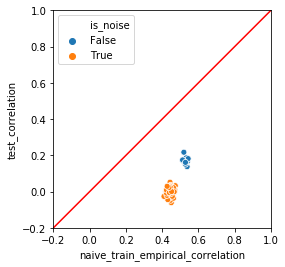

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8258065364890432, 1.2583430410297576e-28)


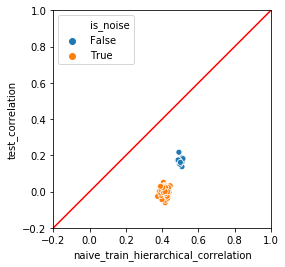

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8133870647375077, 3.6414183722068735e-27)


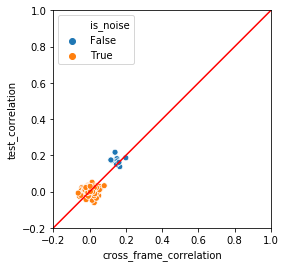

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,-0.013663,0.494352,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,-0.009555,0.632710,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,0.004867,0.807658,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.020744,0.299457,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,0.003021,0.879883,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_8_impact_code',
 'noise_30_impact_code',
 'noise_33_impact_code',
 'noise_79_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,32.953417,22.125107,18.611290,4.016931,8.329277
1,56.313112,22.567463,19.654361,2.231262,4.961036
2,14.644008,-1.837711,4.899909,1.861847,2.383202
3,17.347639,17.751063,11.575775,0.907482,4.277905
4,-3.090683,-3.724826,-2.466523,1.450413,2.619052


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.1155720636032127


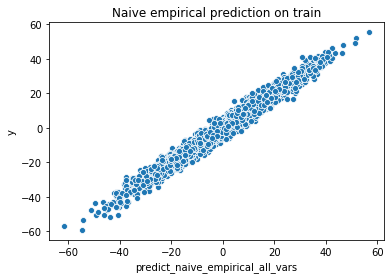

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.56073488480497


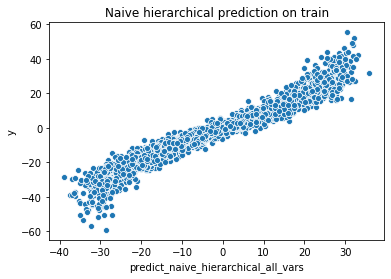

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.153936637709865


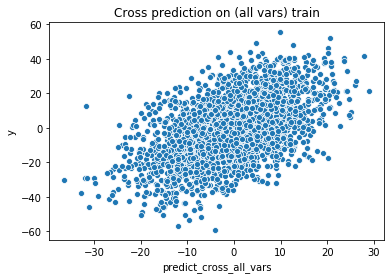

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.557983087694414


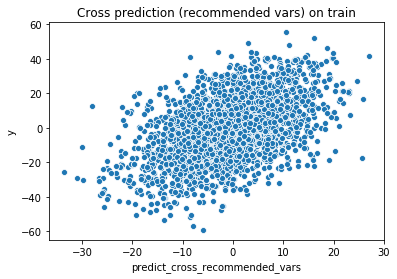

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.550106395523475


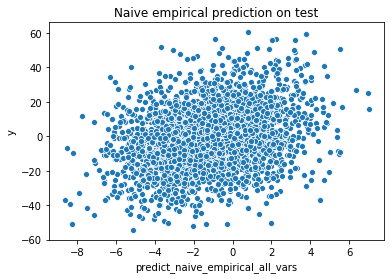

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.21981240385328


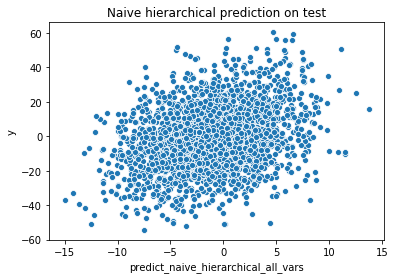

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.750238207066912


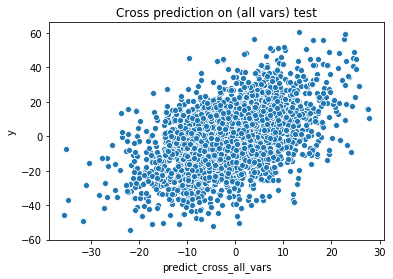

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.471036130701433


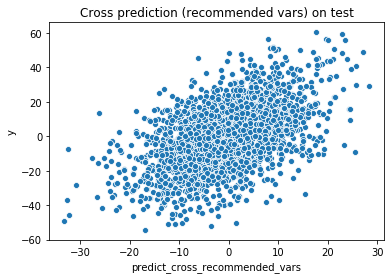

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     698.8
Date:                Sat, 27 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:28:05   Log-Likelihood:                -6398.6
No. Observations:                2504   AIC:                         1.302e+04
Df Residuals:                    2393   BIC:                         1.367e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0312      0.064    -16.191      0.000      -1.156      -0.906
var_0_impact_code        0.0694      0.008      8.711      0.000       0.054       0.085
var_1_impact_code        0.0637      0.008      7.995      0.000       0.048       0.079
var_2_impact_code        0.0677      0.008      8.531      0.000       0.052       0.083
var_3_impact_code        0.0633      0.008      8.042      0.000       0.048       0.079
var_4_impact_code        0.0670      0.008      8.238      0.000       0.051       0.083
var_5_impact_code        0.0546      0.008      6.708      0.000       0.039       0.071
var_6_impact_code        0.0504      0.008      6.276      0.000       0.035       0.066
var_7_impact_code        0.0604      0.008      7.356      0.000       0.044       0.077
var_8_impact_code        0.0665      0.008      8.145      0.000       0.051       0.083
var_9_impact_code        0.0658      0.008      8.169      0.000       0.050       0.082
noise_0_impact_code      0.0507      0.009      5.723      0.000       0.033       0.068
noise_1_impact_code      0.0347      0.009      3.862      0.000       0.017       0.052
noise_2_impact_code      0.0378      0.009      4.109      0.000       0.020       0.056
noise_3_impact_code      0.0355      0.009      3.951      0.000       0.018       0.053
noise_4_impact_code      0.0368      0.009      4.032      0.000       0.019       0.055
noise_5_impact_code      0.0432      0.009      4.772      0.000       0.025       0.061
noise_6_impact_code      0.0488      0.009      5.379      0.000       0.031       0.067
noise_7_impact_code      0.0381      0.009      4.181      0.000       0.020       0.056
noise_8_impact_code      0.0525      0.009      5.954      0.000       0.035       0.070
noise_9_impact_code      0.0439      0.009      4.835      0.000       0.026       0.062
noise_10_impact_code     0.0489      0.009      5.399      0.000       0.031       0.067
noise_11_impact_code     0.0529      0.009      5.909      0.000       0.035       0.070
noise_12_impact_code     0.0356      0.009      3.786      0.000       0.017       0.054
noise_13_impact_code     0.0375      0.009      4.196      0.000       0.020       0.055
noise_14_impact_code     0.0479      0.009      5.222      0.000       0.030       0.066
noise_15_impact_code     0.0266      0.009      2.912      0.004       0.009       0.044
noise_16_impact_code     0.0281      0.009      3.205      0.001       0.011       0.045
noise_17_impact_code     0.0497      0.009      5.658      0.000       0.033       0.067
noise_18_impact_code     0.0509      0.009      5.664      0.000       0.033       0.069
noise_19_impact_code     0.0497      0.009      5.248      0.000       0.031       0.068
noise_20_impact_code     0.0331      0.009      3.564    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9698069759290067

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.05881321441094223

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     8.701
Date:                Sat, 27 Jul 2019   Prob (F-statistic):          1.64e-109
Time:                        16:28:05   Log-Likelihood:                -10360.
No. Observations:                2504   AIC:                         2.094e+04
Df Residuals:                    2393   BIC:                         2.159e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.7600      0.314     -2.419      0.016      -1.376      -0.144
var_0_impact_code        0.4666      0.045     10.333      0.000       0.378       0.555
var_1_impact_code        0.4203      0.046      9.166      0.000       0.330       0.510
var_2_impact_code        0.4468      0.048      9.315      0.000       0.353       0.541
var_3_impact_code        0.3698      0.047      7.920      0.000       0.278       0.461
var_4_impact_code        0.4220      0.048      8.837      0.000       0.328       0.516
var_5_impact_code        0.3820      0.048      8.028      0.000       0.289       0.475
var_6_impact_code        0.3643      0.047      7.690      0.000       0.271       0.457
var_7_impact_code        0.3202      0.048      6.702      0.000       0.226       0.414
var_8_impact_code        0.3699      0.048      7.685      0.000       0.276       0.464
var_9_impact_code        0.4387      0.047      9.243      0.000       0.346       0.532
noise_0_impact_code      0.0446      0.059      0.757      0.449      -0.071       0.160
noise_1_impact_code      0.0014      0.058      0.025      0.980      -0.113       0.116
noise_2_impact_code     -0.0381      0.061     -0.629      0.529      -0.157       0.081
noise_3_impact_code      0.0638      0.059      1.089      0.276      -0.051       0.179
noise_4_impact_code     -0.0026      0.059     -0.045      0.964      -0.118       0.113
noise_5_impact_code     -0.0546      0.057     -0.959      0.338      -0.166       0.057
noise_6_impact_code     -0.0144      0.059     -0.243      0.808      -0.131       0.102
noise_7_impact_code      0.0429      0.060      0.710      0.478      -0.076       0.162
noise_8_impact_code      0.1150      0.055      2.073      0.038       0.006       0.224
noise_9_impact_code     -0.0820      0.059     -1.393      0.164      -0.197       0.033
noise_10_impact_code     0.0656      0.055      1.196      0.232      -0.042       0.173
noise_11_impact_code     0.0296      0.056      0.528      0.597      -0.080       0.139
noise_12_impact_code    -0.1157      0.060     -1.919      0.055      -0.234       0.003
noise_13_impact_code     0.0559      0.058      0.972      0.331      -0.057       0.169
noise_14_impact_code     0.1143      0.063      1.822      0.069      -0.009       0.237
noise_15_impact_code     0.0208      0.055      0.376      0.707      -0.088       0.129
noise_16_impact_code     0.1164      0.056      2.078      0.038       0.007       0.226
noise_17_impact_code     0.0584      0.054      1.092      0.275      -0.047       0.163
noise_18_impact_code    -0.0035      0.057     -0.062      0.951      -0.116       0.109
noise_19_impact_code    -0.0368      0.061     -0.605      0.545      -0.156       0.083
noise_20_impact_code     0.0045      0.060      0.075    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.28569786977501777

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.2419627165880761

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     58.35
Date:                Sat, 27 Jul 2019   Prob (F-statistic):          4.83e-142
Time:                        16:28:06   Log-Likelihood:                -10425.
No. Observations:                2504   AIC:                         2.088e+04
Df Residuals:                    2489   BIC:                         2.097e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8224      0.312     -2.632      0.009      -1.435      -0.210
var_0_impact_code        0.4704      0.045     10.541      0.000       0.383       0.558
var_1_impact_code        0.4177      0.045      9.243      0.000       0.329       0.506
var_2_impact_code        0.4550      0.047      9.623      0.000       0.362       0.548
var_3_impact_code        0.3849      0.046      8.342      0.000       0.294       0.475
var_4_impact_code        0.4161      0.047      8.824      0.000       0.324       0.509
var_5_impact_code        0.3823      0.047      8.154      0.000       0.290       0.474
var_6_impact_code        0.3653      0.047      7.831      0.000       0.274       0.457
var_7_impact_code        0.3379      0.047      7.150      0.000       0.245       0.431
var_8_impact_code        0.3552      0.048      7.470      0.000       0.262       0.448
var_9_impact_code        0.4576      0.047      9.756      0.000       0.366       0.550
noise_8_impact_code      0.1237      0.055      2.260      0.024       0.016       0.231
noise_30_impact_code     0.2004      0.056      3.573      0.000       0.090       0.310
noise_33_impact_code     0.1864      0.057      3.295      0.001       0.075       0.297
noise_79_impact_code     0.1159      0.053      2.192      0.028       0.012       0.220
==============================================================================
Omnibus:                        2.149   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                2.038
Skew:                           0.010   Prob(JB):                        0.361
Kurtosis:                       2.862   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.24709947261140064

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.26859973327372155